In [1]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, hlines, vlines, semilogy

plt.rc("figure", figsize=(20, 20))

In [ ]:
%%writefile fuzzylogic/rules.py
"""Functions to evaluate, infer and defuzzify."""

from math import isinf
from .classes import Domain, Set

def round_partial(value, res):
    """
    Round any value to any arbitrary precision.
    
    >>> round_partial(0.405, 0.02)
    0.4
    >>> round_partial(0.412, 0.02)
    0.42
    >>> round_partial(1.38, 0.25)
    1.5
    >>> round_partial(1.12, 0.25)
    1.0
    >>> round_partial(9.24, 0.25)
    9.25
    >>> round_partial(7.76, 0.25)
    7.75
    >>> round_partial(987654321, 100)
    987654300
    >>> round_partial(3.14, 0)
    3.14
    """
    # backed up by wolframalpha
    if res == 0 or isinf(res):
        return value
    return round(value / res) * res

def rescale(out_min, out_max, *, in_min=0, in_max=1):
    """Scale from one domain to another.
    
    Tests only cover scaling from [0,1] (with default in_min, in_max!)
    to R.
    
    For arbitrary R -> R additional testing is required,
    but it should work in general out of the box.
    
    Originally used the algo from SO
    (OUT_max - OUT_min)*(x - IN_min) / (IN_max - IN_min) + OUT_min
    but there are too many edge cases thanks to over/underflows.
    Current factorized algo was proposed as equivalent by wolframalpha, 
    which seems more stable.
    """
    assert in_min < in_max
    
    # for easier handling of the formula
    a = out_min
    b = out_max
    c = in_min
    d = in_max
        
    def f(x):
        y = (a*d - a*x - b*c + b*x) / (d - c)
        return y
    return f


def weighted_sum(*, weights:dict, target_d:Domain) -> float:
    """Used for weighted decision trees and such.
    
    Parametrize with dict of factorname -> weight and domain of results.
    Call with a dict of factorname -> [0, 1]
    
    There SHOULD be the same number of items (with the same names!)
    of weights and factors, but it doesn't have to be - however
    set(factors.names) <= set(weights.names) - in other words:
    there MUST be at least as many items in weights as factors.
    """
    assert sum(w for w in weights.values()) == 1

    rsc = rescale(target_d._low, target_d._high)
    
    def f(memberships):
        result = sum(r * weights[n] for n, r in memberships.items())
        return round_partial(rsc(result), target_d._res)
    return f

In [ ]:
%%writefile fuzzylogic/hedges.py

"""
Lingual hedges modify curves of membership values.

These work with sets only. It's more trouble than it is worth making
these work with pure functions, so meta-functionality was removed.
"""

from .classes import Set

def very(g):
    """Sharpen memberships so that only the values close 1 stay at the top."""
    def s_f(g):
        def f(x):
            return g(x) ** 2
        return f
    return Set(s_f(g.func))


def plus(g):
    """Sharpen memberships like 'very' but not as strongly."""
    def s_f(g):
        def f(x):
            return g(x) ** 1.25
        return f
    return Set(s_f(g.func))
    

def minus(g):
    """Increase membership support so that more values hit the top."""
    def s_f(g):
        def f(x):
            return g(x) ** 0.75
        return f 
    return Set(s_f(g.func))

In [11]:
%%writefile fuzzylogic/combinators.py

"""
Combine two linguistic terms.

a and b are functions of two sets of the same domain.

Since these combinators are used directly in the Set class to implement logic operations, 
the most obvious use of this module is when subclassing Set to make use of specific combinators
for special circumstances.

Most functions also SHOULD support an arbitrary  number of arguments so they can be used in
other contexts than just fuzzy sets. HOWEVER, mind that the primary set of arguments always are functors and
there is always only one secondary argument - the value to be evaluated.
"""

from functools import reduce
from numpy import multiply

from .functions import noop



def MIN(*funcs):
    """Classic AND variant."""
    def F(z):
        return min(f(z) for f in funcs)
    return F


def MAX(*funcs):
    """Classic OR variant."""
    def F(z):
        return max(f(z) for f in funcs)
    return F


def product(*funcs):
    """AND variant."""
    def F(z):
        return reduce(multiply, (f(z) for f in funcs))
    return F


def bounded_sum(a, b):
    """OR variant."""
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return x + y - x * y
    return f

def lukasiewicz_AND(a, b):
    """AND variant."""
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return min(1, x + y)
    return f

def lukasiewicz_OR(a, b):
    """OR variant."""
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return max(0, x + y - 1)
    return f

def einstein_product(a, b):
    """AND variant."""
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return (x * y) / (2 - (x + y - x * y))
    return f

def einstein_sum(a, b):
    """OR variant."""
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return (x + y) / (1 + x * y)
    return f

def hamacher_product(a, b):
    """AND variant.
    
    (xy) / (x + y - xy) for x, y != 0
    0 otherwise
    """
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return (x * y) / (x + y - x * y) if x != 0 and y != 0 else 0
    return f

def hamacher_sum(a, b):
    """OR variant.
    
    (x + y - 2xy) / (1 - xy) for x,y != 1
    1 otherwise
    """
    # TODO: Expand..
    def f(z):
        x, y = a(z), b(z)
        return (x + y - 2 * x * y) / (1 - x * y) if x != 1 or y != 1 else 1
    return f


def lambda_op(l):
    """A 'compensatoric' operator, combining AND with OR by a weighing factor l.
    
    This complicates matters a little, since all combinators promise to just take 
    2 functions as arguments, so we parametrize this with l.
    """
    # TODO: Expand..
    assert (0 <= l <= 1)
        
    def e(a, b):
        def f(z):
            x, y = a(z), b(z)
            return l * (x * y) + (1 - l) * (x + y - x * y)
        return f
    return e


def gamma_op(g):
    """Combine AND with OR by a weighing factor g.
    
    This is called a 'compensatoric' operator.
    
    g (gamma-factor)
        0 < g < 1 (g == 0 -> AND; g == 1 -> OR)
        
    Same problem as with lambda_op, since all combinators promise to just take 
    2 functions as arguments, so we parametrize this with g.
    """
    # TODO: Expand..
    assert (0 <= g <= 1)
    
    def e(a, b):
        def f(z):
            x, y = a(z), b(z)
            return (x * y) ** (1 - g) * ((1 - x) * (1 - y)) ** g
        return f
    return e

def simple_disjoint_sum(*funcs):
    """Simple fuzzy XOR operation.
    Someone fancy a math proof?
    
    Basic idea:
    (A AND ~B) OR (~A AND B)
    
    >>> xor = simple_disjoint_sum(noop(), noop())
    >>> xor(0)
    0
    >>> xor(1)
    0
    >>> xor(0.5)
    0.5
    >>> xor(0.3) == round(xor(0.7), 2)
    True
    
    Attempt for expansion without proof:
    x = 0.5
    y = 1
    (x and ~y) or (~x and b)

    max(min(0.5, 0), min(0.5, 1)) == 0.5

    ----

    x = 0
    y = 0.5
    z = 1

    (A AND ~B AND ~C) OR (B AND ~A AND ~C) OR (C AND ~B AND ~A)
    max(min(0,0.5,0), min(0.5,1,0), min(1,0.5,1)) == 0.5
    """
    def F(z):
        # Reminder how it works for 2 args
        #x, y = a(z), b(z)  
        #return max(min(x, 1-y), min(1-x, y))  
        
        M = {f(z) for f in funcs}  # a set of all membership values over all given functions to be iterated over
        # we need to go over each value in the set, calc min(x, inverse(rest)), from that calc max
        # for x in args:
        # print(x, [1-y for y in args-set([x])])
        
        # FYI: this works because M-set([x]) returns a new set without x, which we use to construct a new set
        # with inverted values - however, if M only has one value, which is the case if all given values are equal -
        # we have to handle an empty generator expression, which the "or (1-x,)" does.
        # Lastly, the *(...) is needed because min only takes one single iterator, so we need to unzip the rest.
        return max(min((x, *({1-y for y in M-set([x])} or (1-x,)) ))
                   for x in M)
    return F

Overwriting fuzzylogic/combinators.py


In [ ]:
%%writefile fuzzylogic/classes.py

"""
Domain and Set classes for fuzzy logic.

Primary abstractions for recursive functions for better handling.
"""

import matplotlib.pyplot as plt
from numpy import arange, fromiter, array_equal, less_equal, greater_equal, less, greater
import numpy as np
from logging import warn
import pickle

from .functions import inv, normalize
from .combinators import MAX, MIN, product, bounded_sum, simple_disjoint_sum

class FuzzyWarning(UserWarning):
    """Extra Exception so that user code can filter exceptions specific to this lib."""
    pass


class Domain:
    """
    A domain is a 'measurable' dimension of 'real' values like temperature.

    There must be a lower and upper limit and a resolution (the size of steps)
    specified.

    Fuzzysets are defined within one such domain and are only meaningful
    while considered within their domain ('apples and bananas').
    To operate with sets across domains, there needs to be a mapping.

    The sets are accessed as attributes of the domain like
    >>> temp = Domain('temperature', 0, 100)
    >>> temp.hot = Set(lambda x: 0)
    >>> temp.hot(5)
    0

    DO NOT call a derived set without assignment first as it WILL
    confuse the recursion and seriously mess up.
    NOT: ~temp.hot(2) or ~(temp.hot.)(2) 
    BUT:
    >>> not_hot = ~temp.hot
    >>> not_hot(2)
    1

    You MUST NOT add arbitrary attributes to an *instance* of Domain - you can
    however subclass or modify the class itself. If you REALLY have to add attributes, 
    make sure to "whitelist" it in __slots__ first. 

    Use the Domain by calling it with the value in question. This returns a
    dictionary with the degrees of membership per set. You MAY override __call__
    in a subclass to enable concurrent evaluation for performance improvement.
    >>> temp.cold = not_hot
    >>> temp(3) == {"hot": 0, "cold": 1}
    True
    """
    
    __slots__ = ['_name', '_low', '_high', '_res', '_sets']

    def __init__(self, name, low, high, *, res=1, sets:dict=None):
        """Define a domain."""
        assert low < high, "higher bound must be greater than lower."
        assert res > 0, "resolution can't be negative or zero"
        self._name = name
        self._high = high
        self._low = low
        self._res = res
        self._sets = {} if sets is None else sets  # Name: Set(Function())

    
    def __call__(self, x):
        """Pass a value to all sets of the domain and return a dict with results."""
        if not(self._low <= x <= self._high):
            warn(f"{x} is outside of domain!")
        memberships = {name: s.func(x) for name, s in self._sets.items()}
        return memberships

    def __str__(self):
        """Return a string to print()."""
        return self._name
    
    def __repr__(self):
        """Return a string so that eval(repr(Domain)) == Domain."""
        return f"Domain('{self._name}', {self._low}, {self._high}, res={self._res}, sets={self._sets})"
    
    def __eq__(self, other):
        """Test equality of two domains."""
        return all([self._name == other._name,
                   self._low == other._low,
                   self._high == other._high,
                   self._res == other._res,
                   self._sets == other._sets])
    
    def __getattr__(self, name):
        """Get the value of an attribute. Is called after __getattribute__ is called with an AttributeError."""
        if name in self._sets:
            return self._sets[name]
        else:
            raise AttributeError(f"{name} is not a set or attribute")
            
    def __setattr__(self, name, value):
        """Define a set within a domain or assign a value to a domain attribute."""
        # It's a domain attr
        if name in self.__slots__:
            object.__setattr__(self, name, value)
        # We've got a fuzzyset
        else:
            assert str.isidentifier(name), f"{name} must be an identifier."
            if not isinstance(value, Set):
                # Often useful to just assign a function for simple sets..
                value = Set(value)
            # However, we need the abstraction if we want to use Superfuzzysets (derived sets).
            self._sets[name] = value
            value.domain = self
            value.name = name
            
    def __delattr__(self, name):
        """Delete a fuzzy set from the domain."""
        if name in self._sets:
            del self._sets[name]
        else:
            raise FuzzyWarning("Trying to delete a regular attr, this needs extra care.")

    def range(self):
        """Return an arange object with the domain's specifics.
        
        This is used to conveniently iterate over all possible values
        for plotting etc.
        
        High upper bound is INCLUDED unlike range.
        """
        return arange(self._low, self._high + self._res, self._res)
            
    def min(self, x):
        """Standard way to get the min over all membership funcs.
        
        It's not just more convenient but also faster than
        to calculate all results, construct a dict, unpack the dict
        and calculate the min from that.
        """
        return min(f(x) for f in self._sets.values())
    
    def max(self, x):
        """Standard way to get the max over all membership funcs."""
        return max(f(x) for f in self._sets.values())
            
class Set:
    """
    A fuzzyset defines a 'region' within a domain.
    
    The associated membership function defines 'how much' a given value is
    inside this region - how 'true' the value is.

    Sets and functions MUST NOT be mixed because functions don't have
    the methods of the sets needed for the logic.

    Sets that are returned from one of the operations are 'derived sets' or
    'Superfuzzysets' according to Zadeh.
    
    Note that most checks are merely assertions that can be optimized away.
    DO NOT RELY on these checks and use tests to make sure that only valid calls are made.
    
    This class uses the classical MIN/MAX operators for AND/OR. To use different operators, simply subclass and 
    replace the __and__ and __or__ functions. However, be careful not to mix the classes logically, 
    since it might be confusing which operator will be used (left/right binding).
    
    """
    name = None  # these are set on assignment to the domain! DO NOT MODIFY
    domain = None
    
    
    def __init__(self, func:callable, *, name=None, domain=None):
        """Initialize the set."""
        assert callable(func) or isinstance(func, str)
        # if func is a str, we've got a pickled function via repr
        if isinstance(func, str):
            try: 
                func = pickle.loads(func)
            except:
                FuzzyWarning("Can't load pickled function %s" % func)
        self.func = func
        
        if name is not None and domain is not None:
            setattr(domain, name, self)  # Sideeffect - it's the whole magic
        
        if bool(name)^bool(domain):
            raise FuzzyWarning("Name or domain is provided, but not both!")

    def __call__(self, x):
        """Call the function of the set (which can be of any arbitrary complexity)."""
        return self.func(x)

    def __invert__(self):
        """Return a new set with modified function."""
        return Set(inv(self.func))
    
    def __neg__(self):
        return Set(inv(self.func))
    
    def __and__(self, other):
        """Return a new set with modified function."""
        return Set(MIN(self.func, other.func))

    def __or__(self, other):
        """Return a new set with modified function."""
        return Set(MAX(self.func, other.func))

    def __mul__(self, other):
        """Return a new set with modified function."""
        return Set(product(self.func, other.func))

    def __add__(self, other):
        """Return a new set with modified function."""
        return Set(bounded_sum(self.func, other.func))
    
    def __xor__(self, other):
        """Return a new set with modified function."""
        return Set(simple_disjoint_sum(self.func, other.func))

    def __pow__(self, power):
        """Return a new set with modified function."""
        #FYI: pow is used with hedges
        return Set(lambda x: pow(self.func(x), power))
    
    def __eq__(self, other):
        """A set is equal with another if both return the same values over the same range."""
        if self.domain is None or other.domain is None:
            # It would require complete AST analysis to check whether both Sets
            # represent the same recursive functions - 
            # additionally, there are infinitely many mathematically equivalent 
            # functions that don't have the same bytecode...
            raise FuzzyWarning("Impossible to determine.")
        else:
            # however, if domains ARE assigned (whether or not it's the same domain), 
            # we simply can check if they map to the same values 
            return array_equal(self.array(), other.array())
        
    def __le__(self, other):
        """If this <= other, it means this is a subset of the other."""
        if self.domain is None or other.domain is None:
            raise FuzzyWarning("Can't compare without Domains.")
        return all(less_equal(self.array(), other.array()))
    
    def __lt__(self, other):
        """If this < other, it means this is a proper subset of the other."""
        if self.domain is None or other.domain is None:
            raise FuzzyWarning("Can't compare without Domains.")
        return all(less(self.array(), other.array()))
    
    def __ge__(self, other):
        """If this >= other, it means this is a superset of the other."""
        if self.domain is None or other.domain is None:
            raise FuzzyWarning("Can't compare without Domains.")
        return all(greater_equal(self.array(), other.array()))

    def __gt__(self, other):
        """If this > other, it means this is a proper superset of the other."""
        if self.domain is None or other.domain is None:
            raise FuzzyWarning("Can't compare without Domains.")
        return all(greater(self.array(), other.array()))
    
    def __len__(self):
        """Number of membership values in the set, defined by bounds and resolution of domain."""
        if self.domain is None:
            raise FuzzyWarning("No domain.")
        return len(self.array())
    
    def cardinality(self):
        """The sum of all values in the set."""
        if self.domain is None:
            raise FuzzyWarning("No domain.")
        return sum(self.array())

    def relative_cardinality(self):
        """Relative cardinality is the sum of all membership values by number of all values."""
        if self.domain is None:
            raise FuzzyWarning("No domain.")
        if len(self) == 0:
            # this is highly unlikely and only possible with res=inf but still..
            raise FuzzyWarning("The domain has no element.")
        return self.cardinality() / len(self)
    
    def concentrated(self):
        """
        Alternative to hedge "very".
        
        Returns an new set that has a reduced amount of values the set includes and to dampen the
        membership of many values.
        """
        return Set(lambda x: self.func(x) ** 2)

    def intensified(self):
        """
        Alternative to using hedges.
        
        Returns a new set where the membership of values are increased that 
        already strongly belong to the set and dampened the rest.
        """
        def f(x):
            if x < 0.5:
                return 2 * self.func(x)**2
            else:
                return 1 - 2(1 - self.func(x)**2)
        return Set(f)
        
    def dilated(self):
        """Expand the set with more values and already included values are enhanced.
        """
        return Set(lambda x: self.func(x) ** 1./2.)

    def multiplied(self, n):
        """Multiply with a constant factor, changing all membership values."""
        return Set(lambda x: self.func(x) * n)
        
    def plot(self):
        """Graph the set in the given domain."""
        if self.domain is None:
            raise FuzzyWarning("No domain assigned, cannot plot.")
        R = self.domain.range()
        V = [self.func(x) for x in R]
        plt.plot(R, V)
    
    def array(self):
        """Return an array of all values for this set within the given domain."""
        if self.domain is None:
            raise FuzzyWarning("No domain assigned.")
        return fromiter((self.func(x) for x in self.domain.range()), float)

    def __repr__(self):
        """
        Return a string representation of the Set that reconstructs the set with eval().
        
        *******
        Current implementation does NOT work correctly.
        
        This is harder than expected since all functions are (recursive!) closures which
        can't simply be pickled. If this functionality really is needed, all functions 
        would have to be peppered with closure-returning overhead such as
        
        def create_closure_and_function(*args):
            func = None
            def create_function_closure():
                return func

            closure = create_function_closure.__closure__
            func = types.FunctionType(*args[:-1] + [closure])
            return func
        """
        return f"Set({self.func})"
    
    def __str__(self):
        """Return a string for print()."""
        if self.name is None and self.domain is None:
            return f"dangling Set({self.func})"
        else:
            return f"{self.domain._name}.{self.name}"
        
    def normalized(self):
        """Return a set that is normalized *for this domain* with 1 as max."""
        if self.domain is None:
            raise FuzzyWarning("Can't normalize without domain.")
        return Set(normalize(max(self.array()), self.func))

if __name__ == "__main__":
    import doctest
    doctest.testmod()


lets say we're performing a survey, rating beverage, atmosphere, arrangement of food and taste from 1 to 10. no need to actually perform fuzzy logic here, just need to normalize and get a quick result, which we do with Domain.min(x).

In [6]:
%matplotlib inline

from fuzzylogic.classes import Domain, Set
from fuzzylogic.functions import bounded_linear
from fuzzylogic.rules import rescale, round_partial

rating = Domain("ratings", 1, 10, res=0.1)
rating.norm = Set(bounded_linear(1,10))

weights = {"beverage": 0.3, 
           "atmosphere": 0.2, 
           "looks":0.2,
           "taste": 0.3}

def weighted_sum(weights, target):
    rsc = rescale(target._low, target._high)
    
    def f(factors):
        result = sum(r * weights[n] for n, r in factors.items())
        return round_partial(rsc(result), target._res)
    return f


r = weighted_sum(weights=weights, target=rating)

ratings = {"beverage": rating.min(9),
           "atmosphere": rating.min(5),
           "looks": rating.min(4),
            "taste": rating.min(8)}
r(ratings)

6.9

In [ ]:
%%writefile fuzzylogic/truth.py

"""
Functions that transform a given membership value to a truth value.

How this can be useful? Beats me. Found it somewhere on the internet, 
never needed it.
"""
from math import sqrt


def true(m):
    """The membership-value is its own truth-value."""
    return m

def false(m):
    """The opposite of TRUE."""
    return 1 - m

def fairly_false(m):
    """Part of a circle in quadrant I."""
    return sqrt(1 - m ** 2)

def fairly_true(m):
    """Part of a circle in quadrant II."""
    return sqrt(1 - (1 - m) ** 2)

def very_false(m):
    """Part of a circle in quadrant III."""
    return -sqrt(1 - (1 - m) ** 2)

def very_true(m):
    """Part of a circle in quadrant IV."""
    return -sqrt(1 - m ** 2)

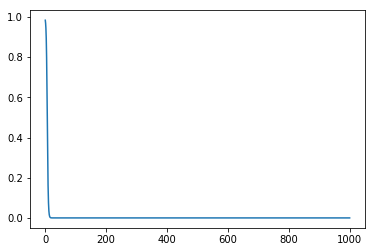

In [7]:
%matplotlib inline

from fuzzylogic.classes import Domain, Set
from fuzzylogic.functions import R, S, bounded_sigmoid

dist = Domain("distance", 0, 1000, res=0.1)
dist.close = Set(bounded_sigmoid(3, 10, inverse=True))
dist.far = Set(R(3, 100))
dist.close.plot()

In [8]:
%%writefile fuzzylogic/functions.py

"""
General-purpose functions that map R -> [0,1].

These functions work as closures. 
The inner function uses the variables of the outer function.

These functions work in two steps: prime and call.
In the first step the function is constructed, initialized and
constants pre-evaluated. In the second step the actual value
is passed into the function, using the arguments of the first step.

Definitions
-----------
These functions are used to determine the *membership* of a value x in a fuzzy-
set. Thus, the 'height' is the variable 'm' in general.
In a normal set there is at least one m with m == 1. This is the default.
In a non-normal set, the global maximum and minimum is skewed.
The following definitions are for normal sets.

The intervals with non-zero m are called 'support', short s_m
The intervals with m == 1 are called 'core', short c_m
The intervals with max(m) are called "height"
The intervals  m != 1 and m != 0 are called 'boundary'.
The intervals with m == 0 are called 'unsupported', short no_m

In a fuzzy set with one and only one m == 1, this element is called 'prototype'.
"""


from math import exp, log, sqrt, isinf, isnan

#####################
# SPECIAL FUNCTIONS #
#####################

def inv(g):
    """Invert the given function within the unit-interval.
    
    For sets, the ~ operator uses this. It is equivalent to the TRUTH value of FALSE.
    """
    def f(x):
        return 1 - g(x)
    return f


def noop():
    """Do nothing and return the value as is.
    
    Useful for testing.
    """
    def f(x):
        return x
    return f

def constant(c):
    """Return always the same value, no matter the input.
    
    Useful for testing.
    >>> f = constant(1)
    >>> f(0)
    1
    """
    def f(x):
        return c
    return f


def alpha(*, floor=0, ceiling=1, func,  
          floor_clip=None, ceiling_clip=None):
    """Clip a function's values.
    
    This is used to either cut off the upper or lower part of a graph.
    Actually, this is more like a hedge but doesn't make sense for sets.
    """
    assert floor <= ceiling
    assert 0 <= floor
    assert ceiling <= 1
    
    floor_clip = floor if floor_clip is None else floor_clip
    ceiling_clip = ceiling if ceiling_clip is None else ceiling_clip
    
    #assert 0 <= floor_clip <= ceiling_clip <= 1, "%s <= %s"%(floor_clip, ceiling_clip)
    
    def f(x):
        m = func(x)
        if m >= ceiling:
            return ceiling_clip
        elif m <= floor:
            return floor_clip
        else: 
            return m
    return f

def normalize(height, func):
    """Map [0,1] to [0,1] so that max(array) == 1."""
    assert 0 < height <= 1
    
    def f(x):
        return func(x) / height
    return f

def moderate(func):
    """Map [0,1] -> [0,1] with bias towards 0.5.

    For instance this is needed to dampen extremes.
    """
    def f(x):
        return 1/2 + 4 * (func(x) - 1/2)**3
    return f
    
########################
# MEMBERSHIP FUNCTIONS #
########################

def singleton(p, *, no_m=0, c_m=1):
    """A single spike.
    
    >>> f = singleton(2)
    >>> f(1)
    0
    >>> f(2)
    1
    """
    assert 0 <= no_m < c_m <= 1

    def f(x):
        return c_m if x == p else no_m
    return f


def linear(m:float=0, b:float=0) -> callable:
    """A textbook linear function with y-axis section and gradient.
    
    f(x) = m*x + b
    BUT CLIPPED.

    >>> f = linear(1, -1)
    >>> f(-2)   # should be -3 but clipped
    0
    >>> f(0)    # should be -1 but clipped
    0
    >>> f(1)
    0
    >>> f(1.5)
    0.5
    >>> f(2)
    1
    >>> f(3)    # should be 2 but clipped
    1
    """
    def f(x) -> float:
        y = m * x + b
        if y <= 0:
            return 0
        elif y >= 1:
            return 1
        else:
            return y
    return f


def bounded_linear(low, high, *, c_m=1, no_m=0, inverse=False):
    """Variant of the linear function with gradient being determined by bounds.

    The bounds determine minimum and maximum value-mappings,
    but also the gradient. As [0, 1] must be the bounds for y-values,
    left and right bounds specify 2 points on the graph, for which the formula
    f(x) = y = (y2 - y1) / (x2 - x1) * (x - x1) + y1 = (y2 - y1) / (x2 - x1) *
                                                                (x - x2) + y2

    (right_y - left_y) / ((right - left) * (x - self.left) + left_y)
    works.
    
    >>> f = bounded_linear(2, 3)
    >>> f(1)
    0.0
    >>> f(2)
    0.0
    >>> f(2.5)
    0.5
    >>> f(3)
    1.0
    >>> f(4)
    1.0
    """
    assert low < high, "low must be less than high"
    assert c_m > no_m, "core_m must be greater than unsupported_m"

    if inverse:
        c_m, no_m = no_m, c_m
    
    gradient = (c_m - no_m) / (high - low)
    
    # special cases found by hypothesis
    
    def g_0(x):
        return (c_m + no_m) / 2
    
    if gradient == 0:
        return g_0
    
    def g_inf(x):
        asymptode = (high + low) / 2
        if x < asymptode:
            return no_m
        elif x > asymptode:
            return c_m
        else:
            return (c_m + no_m) / 2
    
    if isinf(gradient):
        return g_inf
    
    def f(x):
        y = gradient * (x - low) + no_m
        if y < 0:
            return 0.
        if y > 1:
            return 1.
        return y
    return f


def R(low, high):
    """Simple alternative for bounded_linear().
    
    THIS FUNCTION ONLY CAN HAVE A POSITIVE SLOPE -
    USE THE S() FUNCTION FOR NEGATIVE SLOPE.
    """
    assert low < high, f"{low} >? {high}"

    def f(x):
        if x < low or isinf(high - low):
            return 0
        if low <= x <= high:
            return (x - low) / (high - low)
        if x > high:
            return 1
    return f

def S(low, high):
    """Simple alternative for bounded_linear.
    
    THIS FUNCTION ONLY CAN HAVE A NEGATIVE SLOPE -
    USE THE R() FUNCTION FOR POSITIVE SLOPE.
    """
    assert low < high, f"{low}, {high}"

    def f(x):
        if x <= low:
            return 1
        if low < x < high:
            # factorized to avoid nan
            return high / (high - low) - x / (high - low) 
        if high <= x:
            return 0
    return f


def rectangular(low:float, high:float, *, c_m:float=1, no_m:float=0) -> callable:
    """Basic rectangular function that returns the core_y for the core else 0.
    
        ______
        |    |
    ____|    |___
    """
    assert low < high, f'{low}, {high}'

    def f(x:float) -> float:
        if x < low:
            return no_m
        if low <= x <= high:
            return c_m
        if high < x:
            return no_m

    return f


def triangular(low, high, *, c=None, c_m=1, no_m=0):
    r"""Basic triangular norm as combination of two linear functions.

         /\
    ____/  \___

    """
    assert low < high, 'low must be less than high.'
    assert no_m < c_m
    
    c = c if c is not None else (low + high) / 2.
    assert low < c < high, "peak must be inbetween"
    
    left_slope = bounded_linear(low, c, no_m=0, c_m=c_m)
    right_slope = inv(bounded_linear(c, high, no_m=0, c_m=c_m))

    def f(x):
        return left_slope(x) if x <= c else right_slope(x)
    return f


def trapezoid(low, c_low, c_high, high, *, c_m=1, no_m=0):
    r"""Combination of rectangular and triangular, for convenience.
    
          ____
         /    \
    ____/      \___

    """
    assert low < c_low <= c_high < high
    assert 0 <= no_m < c_m <= 1 

    left_slope = bounded_linear(low, c_low, c_m=c_m, no_m=no_m)
    right_slope = bounded_linear(c_high, high, c_m=c_m, no_m=no_m,
                                inverse=True)

    def f(x):
        if x < low or high < x:
            return no_m
        elif x < c_low:
            return left_slope(x)
        elif x > c_high:
            return right_slope(x)
        else:
            return c_m

    return f


def sigmoid(L, k, x0):
    """Special logistic function.

    http://en.wikipedia.org/wiki/Logistic_function

    f(x) = L / (1 + e^(-k*(x-x0)))
    with
    x0 = x-value of the midpoint
    L = the curve's maximum value
    k = steepness
    """
    # need to be really careful here, otherwise we end up in nanland
    assert 0 < L <= 1, 'L invalid.'

    def f(x):
        if isnan(k*x):
            # e^(0*inf) = 1
            o = 1
        else:
            try:
                o = exp(-k*(x - x0))
            except OverflowError:
                o = float("inf")
        return L / (1 + o)

    return f


def bounded_sigmoid(low, high, inverse=False):
    """
    Calculate a weight based on the sigmoid function.

    Specify the lower limit where f(x) = 0.1 and the
    upper with f(x) = 0.9 and calculate the steepness and elasticity
    based on these. We don't need the general logistic function as we
    operate on [0,1].
    
    core idea:
    f(x) = 1. / (1. + exp(x * (4. * log(3)) / (low - high)) * 
                9 * exp(low * -(4. * log(3)) / (low - high)))
    
    How I got this? IIRC I was playing around with linear equations and 
    boundary conditions of sigmoid funcs on wolframalpha..
    
    previously factored to:
    k = -(4. * log(3)) / (low - high)
    o = 9 * exp(low * k)
    return 1 / (1 + exp(-k * x) * o)
    
    vars
    ----
    low: x-value with f(x) = 0.1
    for x < low: m -> 0
    high: x-value with f(x) = 0.9
    for x > high: m -> 1

    >>> f = bounded_sigmoid(0, 1)
    >>> f(0)
    0.1
    >>> round(f(1), 2)
    0.9
    >>> round(f(100000), 2)
    1.0
    >>> round(f(-100000), 2)
    0.0
    """
    assert low < high, 'low must be less than high'
    
    if inverse:
        low, high = high, low
    
    k = (4. * log(3)) / (low - high)
    try:
        # if high - low underflows to 0..
        if isinf(k):
            p = 0
        # just in case k -> 0 and low -> inf
        elif isnan(-k * low):
            p = 1
        else:
            p = exp(-k * low)
    except OverflowError:
        p = float("inf")
    
    def f(x):
        try:
            # e^(0*inf) = 1 for both -inf and +inf
            if (isinf(k) and x == 0) or (k == 0 and isinf(x)):
                q = 1
            else: q = exp(x * k)
        except OverflowError:
            q = float("inf")
        
        # e^(inf)*e^(-inf) = 1
        r = p * q
        if isnan(r):
            r = 1
        return 1 / (1 + 9 * r)
    return f

def bounded_exponential(k=0.1, limit=1):
    """Function that goes through the origin and approaches a limit.
    k determines the steepness. The function defined for [0, +inf).
    Useful for things that can't be below 0 but may not have a limit like temperature
    or time, so values are always defined.
    f(x)=limit-limit/e^(k*x)

    Again: This function assumes x >= 0, there are no checks for this assumption!
    """
    assert limit > 0
    assert k > 0
    def f(x):
        return limit - limit/exp(k*x)
    return f

def simple_sigmoid(k=0.229756):
    """Sigmoid variant with only one parameter (steepness).

    The midpoint is 0.
    The slope is positive for positive k and negative k.
    f(x) is within [0,1] for any real k and x.
    >>> f = simple_sigmoid()
    >>> round(f(-1000), 2)
    0.0
    >>> f(0)
    0.5
    >>> round(f(1000), 2)
    1.0
    >>> round(f(-20), 2)
    0.01
    >>> round(f(20), 2)
    0.99
    """
    def f(x):
        # yay for limits..
        if (isinf(x) and k == 0):
            return 1/2
        else:
            try:
                return 1 / (1 + exp(x * -k))
            except OverflowError:
                return 0.
    return f


def triangular_sigmoid(low, high, c=None):
    """Version of triangular using sigmoids instead of linear.
    
    THIS FUNCTION PEAKS AT 0.9

    >>> g = triangular_sigmoid(2, 4)
    >>> g(2)
    0.1
    >>> round(g(3), 2)
    0.9
    """
    assert low < high, "low must be less than high"
    c = c if c is not None else (low + high) / 2.
    assert low < c < high, "c must be inbetween"

    left_slope = bounded_sigmoid(low, c)
    right_slope = inv(bounded_sigmoid(c, high))

    def f(x):
        if x <= c:
            return left_slope(x)
        else:
            return right_slope(x)

    return f


def gauss(c, b, *, c_m=1):
    """Defined by ae^(-b(x-x0)^2), a gaussian distribution.
    
    Basically a triangular sigmoid function, it comes close to human perception.

    vars
    ----
    c_m (a)
        defines the maximum y-value of the graph
    b
        defines the steepness
    c (x0)
        defines the symmetry center/peak of the graph
    """
    assert 0 < c_m <= 1
    assert 0 < b, "b must be greater than 0"

    def f(x):
        try:
            o = (x - c)**2
        except OverflowError:
            return 0
        return c_m * exp(-b * o)
    return f


if __name__ == "__main__":
    import doctest
    doctest.testmod()

Overwriting fuzzylogic/functions.py


In [2]:
%cd src/fuzzylogic/

import classes, functions

from hedges import very

/media/sf_Dropbox/code/fuzzylogic/src/fuzzylogic


In [3]:
temp = classes.Domain("Temperature", -80, 80)
hum = classes.Domain("Humidity", 0, 100)
motor = classes.Domain("Speed", 0, 2000)

temp.hot = functions.R(30,40)
temp.cold = functions.S(0,15)

hum.dry = functions.S(20,40)
hum.wet = functions.R(40,70)

motor.fast = functions.R(1000,1500)

motor.slow = ~motor.fast

In [3]:
R1 = classes.Rule({(temp.hot, hum.dry): motor.fast})
R2 = classes.Rule({(temp.cold, hum.dry): very(motor.slow)})
R3 = classes.Rule({(temp.hot, hum.wet): very(motor.fast)})
R4 = classes.Rule({(temp.cold, hum.wet): motor.slow})

Rules = classes.Rule({(temp.hot, hum.dry): motor.fast,
              (temp.cold, hum.dry): very(motor.slow),
              (temp.hot, hum.wet): very(motor.fast),
              (temp.cold, hum.wet): motor.slow
             })

Rules == R1 | R2 | R3 | R4 == sum([R1, R2, R3, R4])

True

In [4]:
Rules[(temp.hot, hum.dry)]

Set(<function R.<locals>.f at 0x7fc23f65f310>)

In [5]:
temp(5)

{<function functions.R.<locals>.f(x)>: 0,
 <function functions.S.<locals>.f(x)>: 0.6666666666666667}

In [4]:
Rules(temp(5), hum(40))

NameError: name 'Rules' is not defined

In [3]:
import classes, functions

from hedges import very

temp = classes.Domain("Temperature", -80, 80)
hum = classes.Domain("Humidity", 0, 100)
motor = classes.Domain("Speed", 0, 2000)

temp.hot = functions.R(15,30)
temp.cold = functions.S(0,20)

hum.dry = functions.S(20,50)
hum.wet = functions.R(40,70)

motor.fast = functions.R(1000,1500)
motor.slow = ~motor.fast
motor.failsafe = functions.R(motor._low, motor._high)

R1 = classes.Rule({(temp.hot, hum.dry): motor.fast})
R2 = classes.Rule({(temp.cold, hum.dry): very(motor.slow)})
R3 = classes.Rule({(temp.hot, hum.wet): very(motor.fast)})
R4 = classes.Rule({(temp.cold, hum.wet): motor.slow})

Rules = classes.Rule({(temp.hot, hum.dry): motor.fast,
                      (temp.cold, hum.dry): very(motor.slow),
                      (temp.hot, hum.wet): very(motor.fast),
                      (temp.cold, hum.wet): motor.slow,
                      })

Rules == R1 | R2 | R3 | R4 == sum([R1, R2, R3, R4])

True

In [6]:
res = [Rules(temp(t), hum(h)) for t in range(-80,80) for h in range(0,100)]

In [8]:
import numpy as np

In [9]:
R = np.fromiter(res, float)

In [10]:
R.shape

(16000,)

In [11]:
R = np.reshape(R, (100,160))

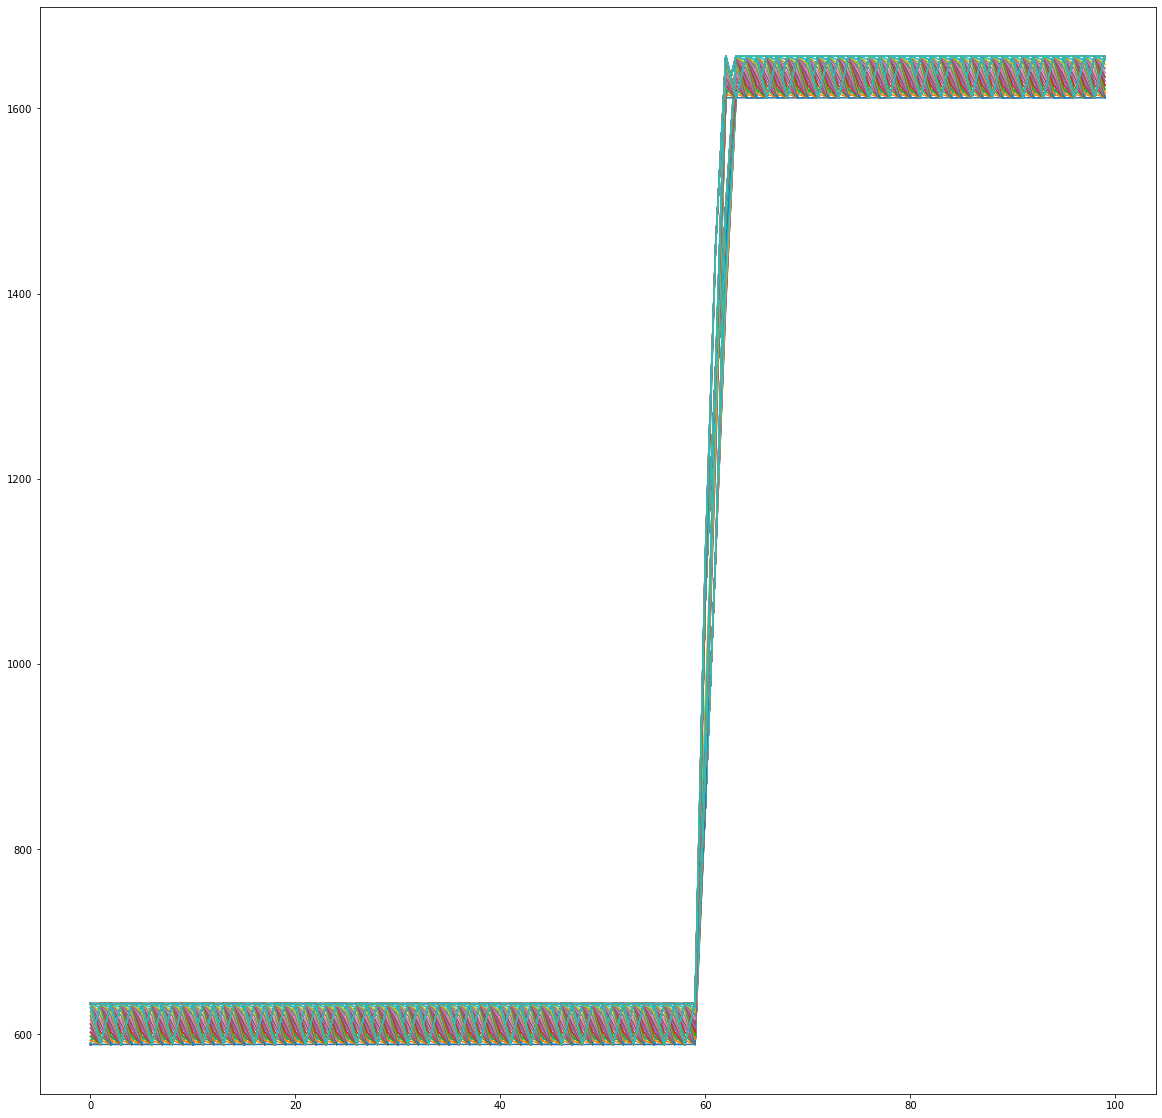

In [12]:
plot(R)

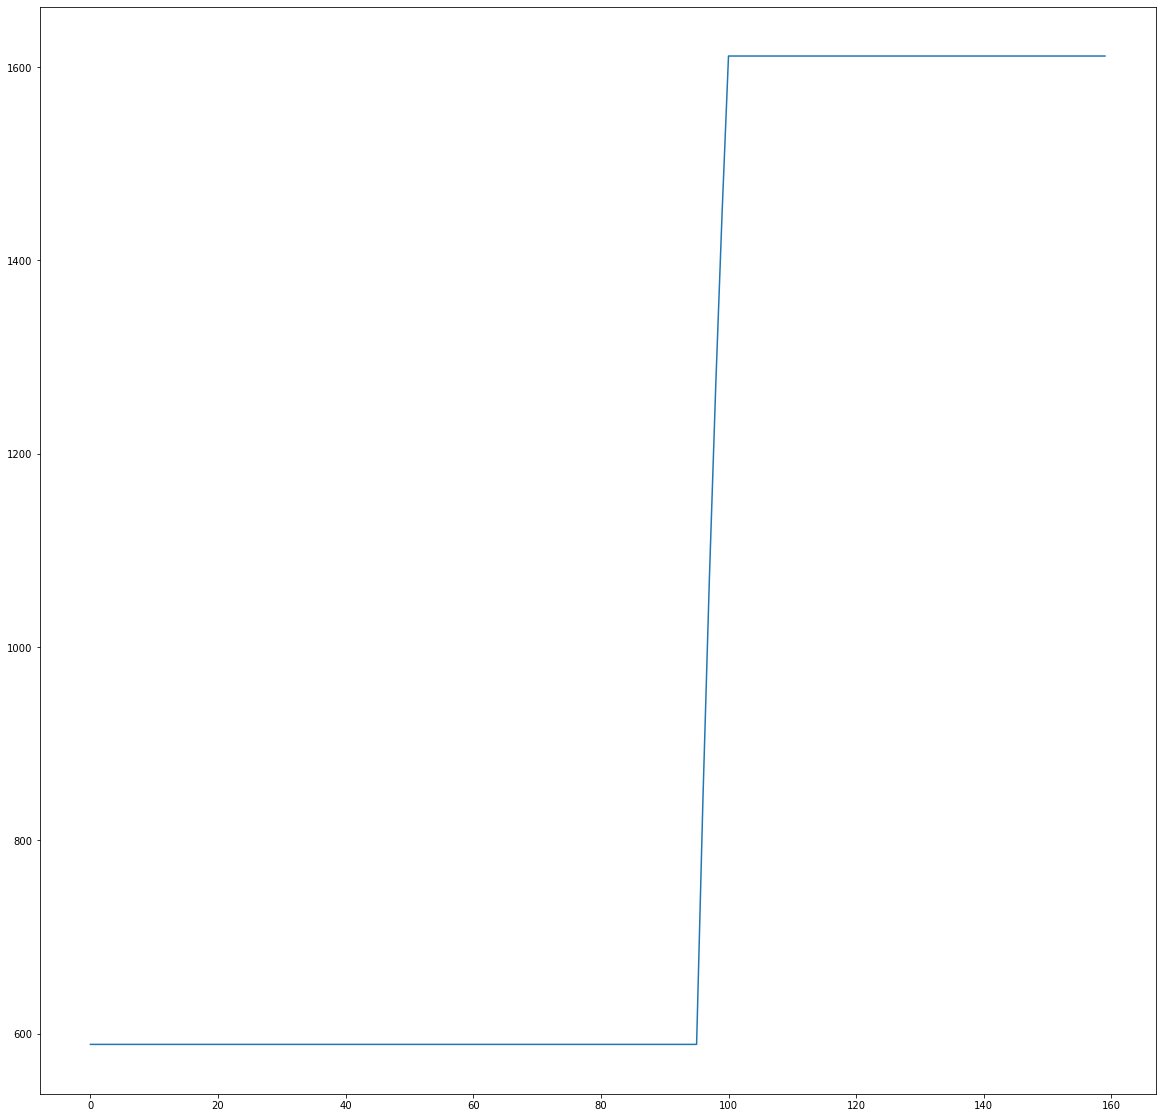

In [11]:
plot(res)

In [19]:
Z = np.fromiter(res, dtype=float)
Z = np.reshape(Z, (160,100))